In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import joblib
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

In [2]:
drop_cols = [
    # Features with high correlation # Enhanced Intrusion Detection Systems Performance with UNSW-NB15 Data Analysis
    'sloss',
    'dloss',
    'dpkts',
    'dwin',
    'ltime',
    'ct_srv_dst',
    'ct_src_dport_ltm',
    'ct_dst_src_ltm',
    # Features providing individual session specific details
    'srcip',
    'sport',
    'dstip',
    'dsport',
]

In [3]:
# Define the path for the feature names CSV file
features_file = 'input/NUSW-NB15_features.csv'

# Load feature names from the CSV file
features_df = pd.read_csv(features_file, encoding='ISO-8859-1')

# Process the column names to remove spaces and convert to lower case
column_names = features_df['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

# Gather all dataset CSV file paths excluding the features file
dataset_paths = [os.path.join('input', filename) for filename in os.listdir('input') if filename.endswith('.csv') and filename != 'NUSW-NB15_features.csv']

# Initialize an empty DataFrame to store the merged data
complete_df = pd.DataFrame()

# Load each dataset and concatenate it into complete_df
for file in dataset_paths:
    df = pd.read_csv(file, header=None, names=column_names)
    complete_df = pd.concat([complete_df, df], ignore_index=True)
    print(f"Successfully loaded {file}")

print(complete_df.shape)

C:\Users\Jeffson\AppData\Local\Temp\ipykernel_22216\4200030863.py:18: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, header=None, names=column_names)


Successfully loaded input\UNSW-NB15_1.csv


C:\Users\Jeffson\AppData\Local\Temp\ipykernel_22216\4200030863.py:18: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, header=None, names=column_names)


Successfully loaded input\UNSW-NB15_2.csv
Successfully loaded input\UNSW-NB15_3.csv
Successfully loaded input\UNSW-NB15_4.csv
(2540047, 49)


# Data Cleaning

In [4]:
complete_df.isnull().sum()

srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports     

## Cleaning null values

In [5]:
# fill Null values with '0' in 'ct_flw'http_mthd'
complete_df['ct_flw_http_mthd'] = complete_df.ct_flw_http_mthd.fillna(value=0)

# fill Null values with '0' in 'is_ftp_login'
complete_df['is_ftp_login'] = complete_df.is_ftp_login.fillna(value=0)

# fill Null values with 'normal' for normal attacks in 'attack_cat'
complete_df['attack_cat'] = complete_df.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

print('After cleaning null values: \n', complete_df.isnull().sum())

After cleaning null values: 
 srcip               0
sport               0
dstip               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
stime               0
ltime               0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct

## 'is_ftp_login' is a binary attribute but has values other than 0 and 1, so remove all except 0 and 1

In [6]:
print('Before: \n', complete_df['is_ftp_login'].value_counts())
complete_df['is_ftp_login'] = np.where(complete_df['is_ftp_login']>1, 1, complete_df['is_ftp_login'])

Before: 
 is_ftp_login
0.0    2496472
1.0      43389
4.0        156
2.0         30
Name: count, dtype: int64


In [7]:
print('After: \n', complete_df['is_ftp_login'].value_counts())

After: 
 is_ftp_login
0.0    2496472
1.0      43575
Name: count, dtype: int64


## ‘ct_ftp_cmd’ attribute has blank entries and it is supposed to be numerical

In [8]:
print('Entries in this attribute:', complete_df['ct_ftp_cmd'].unique())
print('Data type:', complete_df['ct_ftp_cmd'].dtype)
complete_df['ct_ftp_cmd'] = complete_df['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

Entries in this attribute: [0 1 6 2 4 8 5 3 '0' '1' ' ' '2' '4']
Data type: object


In [9]:
print("After Cleaning 'ct_ftp_cmd'")
print('Entries in this attribute:', complete_df['ct_ftp_cmd'].unique())
print('Data type:', complete_df['ct_ftp_cmd'].dtype)

After Cleaning 'ct_ftp_cmd'
Entries in this attribute: [0 1 6 2 4 8 5 3]
Data type: int32


## 'service' is a categorical attribute but has value "-"

In [10]:
print('Before: \n', complete_df['service'].value_counts())
complete_df['service'] = complete_df['service'].apply(lambda x: "None" if x == "-" else x)

Before: 
 service
-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64


In [11]:
print('After: \n', complete_df['service'].value_counts())

After: 
 service
None        1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64


## Replace 'backdoors' attribute to the correct name 'backdoor'

In [12]:
print('Before:', complete_df['attack_cat'].value_counts())
complete_df['attack_cat'] = complete_df['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

Before: attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             1795
shellcode            1511
backdoors             534
worms                 174
Name: count, dtype: int64


In [13]:
print('After:', complete_df['attack_cat'].value_counts())

After: attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64


In [14]:
# Dropping features
complete_df.drop(columns=drop_cols, inplace=True, errors='ignore')
print(f'Shape after dropping columns: {complete_df.shape}')

# Remove rows with 'NaN', '+inf', '-inf' values
complete_df.replace([np.inf, -np.inf], np.nan, inplace=True)
complete_df.dropna(inplace=True)
print(f'Shape after removing invalid data: {complete_df.shape}')

# Remove duplicate rows
complete_df.drop_duplicates(inplace=True)
complete_df.reset_index(drop=True, inplace=True)

print(f'Shape after removing duplicated rows: {complete_df.shape}')

Shape after dropping columns: (2540047, 37)
Shape after removing invalid data: (2540047, 37)
Shape after removing duplicated rows: (2057485, 37)


## Feature Encoding

In [15]:
complete_df.select_dtypes(exclude=np.number).columns

Index(['proto', 'state', 'service', 'attack_cat'], dtype='object')

In [16]:
# Fit and transform the 'attack_cat' column
label_encoder = LabelEncoder()
complete_df['attack_cat'] = label_encoder.fit_transform(complete_df['attack_cat'])

# Display unique classes after label encoding
print(f'Classes: {label_encoder.classes_}')
print(f'Encoded labels: {complete_df["attack_cat"].value_counts()}')

Classes: ['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
Encoded labels: attack_cat
6    1958103
3      27596
5      25284
4      21637
7      13352
2       5665
0       2184
1       1983
8       1511
9        170
Name: count, dtype: int64


In [17]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Initialize an empty DataFrame to hold all new one-hot encoded features
encoded_features = pd.DataFrame()

categorical_features = ['proto', 'state', 'service']

# Fit and transform data
encoded_data = encoder.fit_transform(complete_df[categorical_features]).toarray()  # Convert to dense array

# Generate correct column names using get_feature_names_out()
column_names = encoder.get_feature_names_out()

# Convert the encoded data into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

# Drop the original categorical columns from complete_df
complete_df.drop(columns=categorical_features, inplace=True)

# Concatenate the original DataFrame with the new encoded DataFrame
complete_df = pd.concat([complete_df, encoded_df.reset_index(drop=True)], axis=1)

## Reduce dataset size by converting data types from int64 to int16 and float64 to float32

In [18]:
int_col = complete_df.select_dtypes(include='integer').columns
complete_df[int_col] = complete_df[int_col].astype('int16')

float_col = complete_df.select_dtypes(include='float').columns
complete_df[float_col] = complete_df[float_col].astype('float32')

## Split Data

In [19]:
# Retrieving Features and Labels
features = complete_df.drop(['attack_cat', 'label'], axis=1)
target = complete_df['attack_cat']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

## Standardization

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hybrid Machine Learning

- Random Forest is senstive to overfitting with noisy datasets, XGBoost applies regularization to reduce overfitting

- XGBoost can be computationally intensive and requires careful parameter tuning, while Random Forest is less sensitive to hyperparameters and consistently performs well

- Random Forest averages decisions from multiple trees (bagging), while XGBoost builds trees sequentially to correct errors (boosting). This varied approach captures different data patterns, boosting accuracy and robustness.

Overfitting: performs very well for training data but has poor performance with test data

## RF-XGBoost Stacking Classifier with Logistic Regression Final Estimator

In [22]:
rf_model = joblib.load('rf_model.pkl',  mmap_mode='r')
xgb_model = joblib.load('xgb_model.pkl',  mmap_mode='r')

rf_xgb_stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    stack_method='auto',
)

rf_xgb_stacking_clf.fit(X_train_scaled, y_train)
rf_xgb_stacking_y_predict = rf_xgb_stacking_clf.predict(X_test_scaled)

print("RF-XGB Stacking Classifier with Logistic Regression Final Estimator Report")
print(classification_report(y_test, rf_xgb_stacking_y_predict))

rf_xgb_stacking_accuracy = accuracy_score(y_test, rf_xgb_stacking_y_predict)
rf_xgb_stacking_precision = precision_score(y_test, rf_xgb_stacking_y_predict, average='weighted')
rf_xgb_stacking_recall = recall_score(y_test, rf_xgb_stacking_y_predict, average='weighted')
rf_xgb_stacking_f1 = f1_score(y_test, rf_xgb_stacking_y_predict, average='weighted')

print("\nRF-XGB Stacking Classifier Metrics (Logistic Regression Final Estimator):")
print(f"Accuracy of RF-XGB Stacking Classifier: {rf_xgb_stacking_accuracy:.4f}")
print(f"Precision of RF-XGB Stacking Classifier: {rf_xgb_stacking_precision:.4f}")
print(f"Recall of RF-XGB Stacking Classifier: {rf_xgb_stacking_recall:.4f}")
print(f"F1-measure of RF-XGB Stacking Classifier: {rf_xgb_stacking_f1:.4f}")

# Clear memory
joblib.dump(rf_xgb_stacking_clf, 'rf_xgb_stacking_clf.pkl')
del rf_model, xgb_model, rf_xgb_stacking_clf
gc.collect()

RF-XGB Stacking Classifier with Logistic Regression Final Estimator Report
              precision    recall  f1-score   support

           0       0.42      0.54      0.47       415
           1       0.52      0.53      0.53       432
           2       0.48      0.42      0.45      1149
           3       0.79      0.82      0.81      5478
           4       0.65      0.61      0.63      4296
           5       0.94      0.88      0.91      5007
           6       1.00      1.00      1.00    391741
           7       0.89      0.80      0.84      2662
           8       0.59      0.60      0.60       289
           9       0.80      0.14      0.24        28

    accuracy                           0.99    411497
   macro avg       0.71      0.63      0.65    411497
weighted avg       0.99      0.99      0.99    411497


RF-XGB Stacking Classifier Metrics (Logistic Regression Final Estimator):
Accuracy of RF-XGB Stacking Classifier: 0.9854
Precision of RF-XGB Stacking Classifier: 0.9

9

## RF-SVM Stacking Classifier with Logistic Regression Final Estimator

In [21]:
rf_model = joblib.load('rf_model.pkl',  mmap_mode='r')
svm_model = joblib.load('svm_model.pkl',  mmap_mode='r')

rf_svm_stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model)
    ],
    final_estimator=LogisticRegression(),
    stack_method='auto',
)

rf_svm_stacking_clf.fit(X_train_scaled, y_train)
rf_svm_stacking_y_predict = rf_svm_stacking_clf.predict(X_test_scaled)

print("RF-SVM Stacking Classifier with Logistic Regression Final Estimator Report")
print(classification_report(y_test, rf_svm_stacking_y_predict))

rf_svm_stacking_accuracy = accuracy_score(y_test, rf_svm_stacking_y_predict)
rf_svm_stacking_precision = precision_score(y_test, rf_svm_stacking_y_predict, average='weighted')
rf_svm_stacking_recall = recall_score(y_test, rf_svm_stacking_y_predict, average='weighted')
rf_svm_stacking_f1 = f1_score(y_test, rf_svm_stacking_y_predict, average='weighted')

print("\nRF-SVM Stacking Classifier Metrics (Logistic Regression Final Estimator):")
print(f"Accuracy of RF-SVM Stacking Classifier: {rf_svm_stacking_accuracy:.4f}")
print(f"Precision of RF-SVM Stacking Classifier: {rf_svm_stacking_precision:.4f}")
print(f"Recall of RF-SVM Stacking Classifier: {rf_svm_stacking_recall:.4f}")
print(f"F1-measure of RF-SVM Stacking Classifier: {rf_svm_stacking_f1:.4f}")

# Clear memory
joblib.dump(rf_svm_stacking_clf, 'rf_svm_stacking_clf.pkl')
del rf_model, svm_model, rf_svm_stacking_clf
gc.collect()

c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, in

RF-SVM Stacking Classifier with LogisticRegression Final Estimator Report
              precision    recall  f1-score   support

           0       0.12      0.04      0.06       415
           1       0.33      0.00      0.00       432
           2       0.14      0.14      0.14      1149
           3       0.75      0.79      0.77      5478
           4       0.58      0.52      0.54      4296
           5       0.90      0.83      0.86      5007
           6       0.99      1.00      1.00    391741
           7       0.69      0.80      0.74      2662
           8       0.80      0.12      0.21       289
           9       0.00      0.00      0.00        28

    accuracy                           0.98    411497
   macro avg       0.53      0.42      0.43    411497
weighted avg       0.98      0.98      0.98    411497


RF-SVM Stacking Classifier Metrics (Logistic Regression Final Estimator):
Accuracy of RF-SVM Stacking Classifier: 0.9808
Precision of RF-SVM Stacking Classifier: 0.97

0

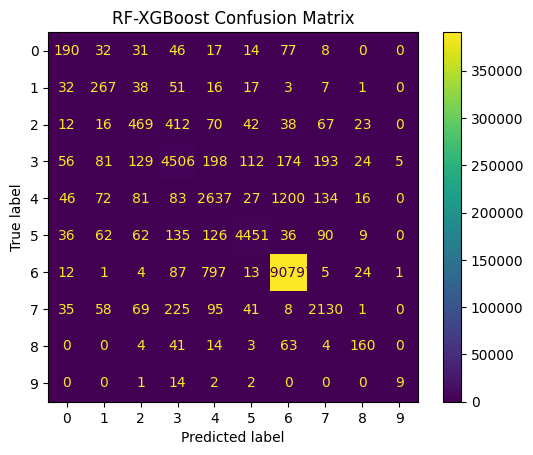

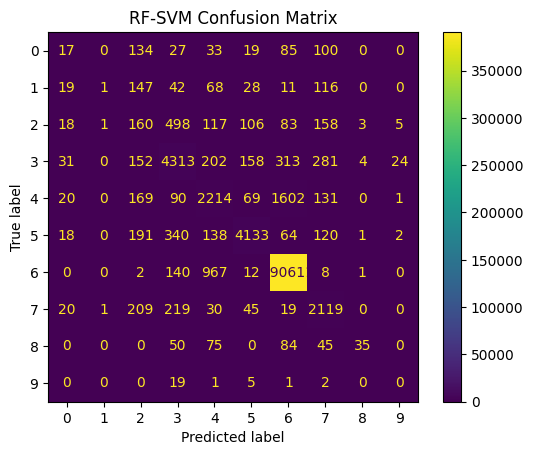

In [25]:
rf_xgb_cm = confusion_matrix(y_test,  rf_xgb_stacking_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_xgb_cm)
disp.plot()
plt.title('RF-XGBoost Confusion Matrix')
plt.show()

rf_svm_cm = confusion_matrix(y_test, rf_svm_stacking_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_svm_cm)
disp.plot()
plt.title('RF-SVM Confusion Matrix')
plt.show()

In [ ]:
# Print the confusion matrices
print("Random Forest-XGBoost Confusion Matrix:\n", rf_xgb_cm)
print("\nRF-SVM Confusion Matrix:\n", rf_svm_cm)

Comparison of Macro Average F1-Scores

                 Model  Macro F1-Score
0        Random Forest            0.54
1                  SVM            0.39
2  Logistic Regression            0.39
3              XGBoost            0.57
4      RF-XGB Stacking            0.66
5      RF-SVM Stacking            0.43


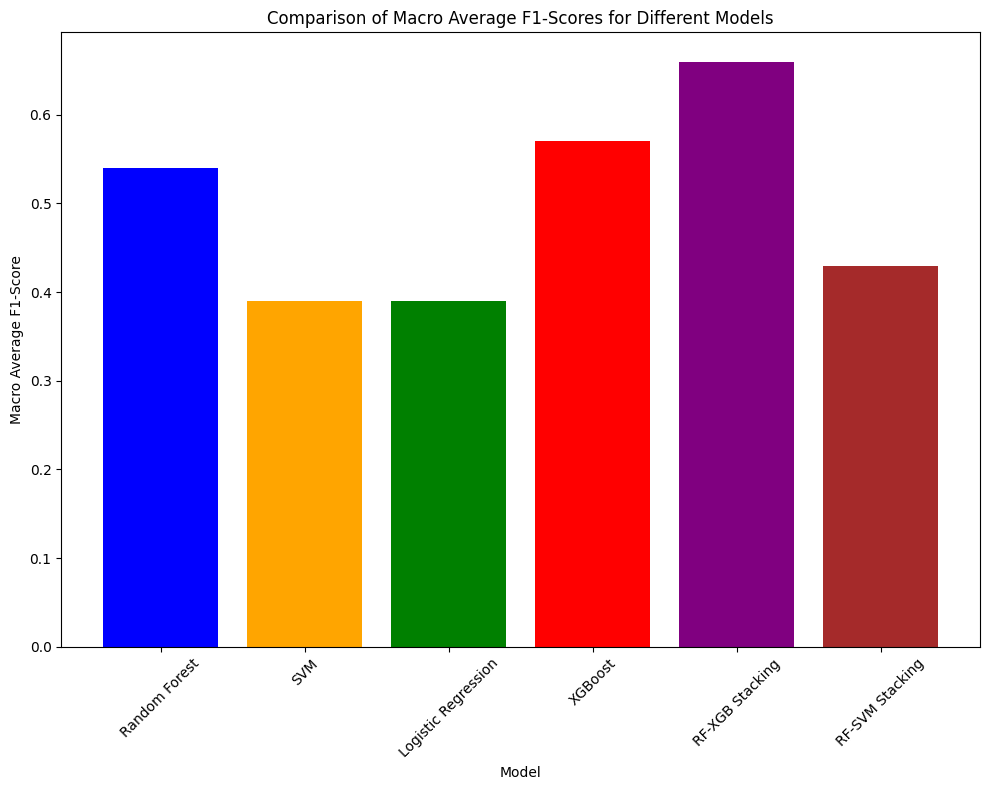

In [28]:
f1_scores = {
    'Model': ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost', 'RF-XGB Stacking', 'RF-SVM Stacking'],
    'Macro F1-Score': [
        0.54,  # Random Forest macro average F1-score
        0.39,  # SVM macro average F1-score
        0.39,  # Logistic Regression macro average F1-score
        0.57,  # XGBoost macro average F1-score
        0.66,  # RF-XGB Stacking macro average F1-score
        0.43   # RF-SVM Stacking macro average F1-score
    ]
}

# Creating a DataFrame for comparison
comparison_df = pd.DataFrame(f1_scores)

# Display the comparison table
print("Comparison of Macro Average F1-Scores\n")
print(comparison_df)

# Visualizing the Comparison
plt.figure(figsize=(10, 8))
plt.bar(comparison_df['Model'], comparison_df['Macro F1-Score'], color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Model')
plt.ylabel('Macro Average F1-Score')
plt.title('Comparison of Macro Average F1-Scores for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Assessment of Machine Learning Models in Addressing High False Alarm Rates:

                              Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9  Average False Positive Rate
Hybrid Random Forest-XGBoost    0.06%    0.08%    0.10%    0.27%    0.33%    0.07%    8.09%    0.12%    0.02%    0.00%                        0.91%
Hybrid Random Forest-SVM        0.03%    0.00%    0.24%    0.35%    0.40%    0.11%   11.45%    0.24%    0.00%    0.01%                        1.28%


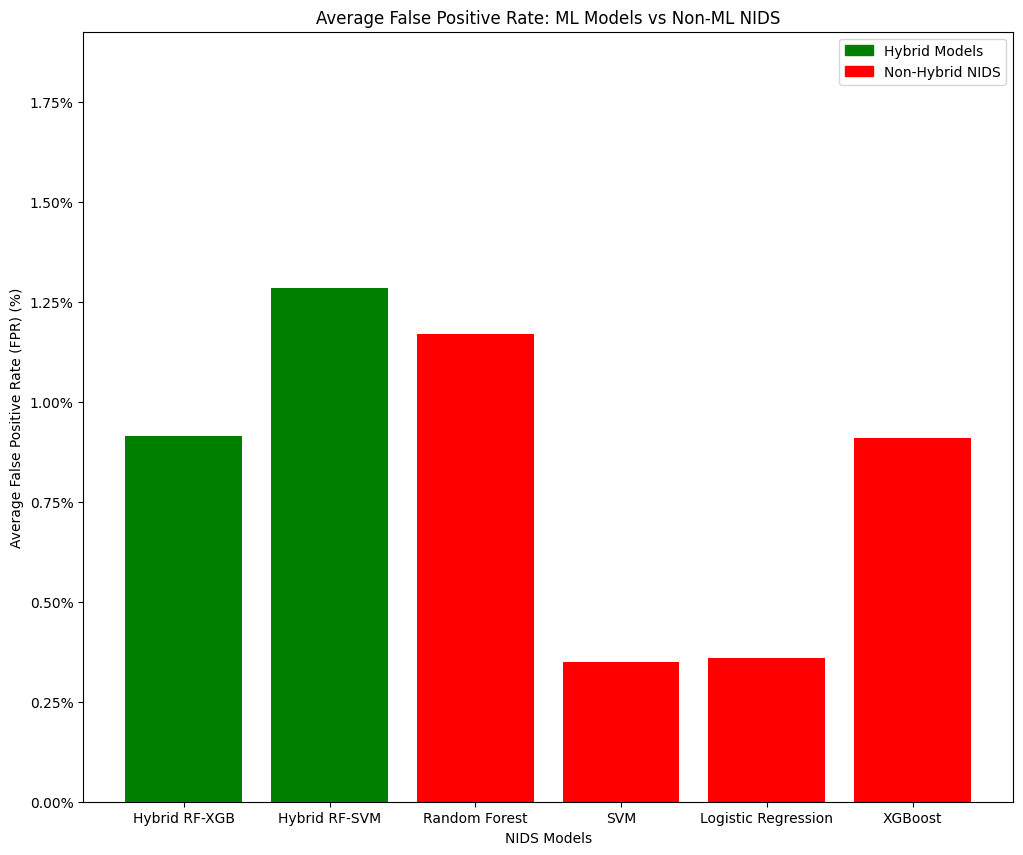

In [51]:
confusion_matrices = {
    'Hybrid RF-XGB': rf_xgb_cm,
    'Hybrid RF-SVM': rf_svm_cm,
}

print("Assessment of Machine Learning Models in Addressing High False Alarm Rates:\n")

model_fprs = {}
fpr_data = []

for model_name, cm in confusion_matrices.items():
    # Calculate TP, FP, FN, TN
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)
    
    # False Positive Rate (False Alarm Rate) for each class 
    FPR = FP / (FP + TN)
    
    # Average False Positive Rate across all classes
    average_FPR = np.mean(FPR)
    model_fprs[model_name] = average_FPR
    
    # Table
    fpr_data.append(np.append(FPR, average_FPR))

# Convert collected data to a DataFrame
index = ['Hybrid Random Forest-XGBoost', 'Hybrid Random Forest-SVM']
columns = [f'Class {i}' for i in range(len(FPR))] + ['Average False Positive Rate']
fpr_df = pd.DataFrame(fpr_data, index=index, columns=columns) * 100
formatted_fpr_df = fpr_df.style.format("{:.2f}%")

pd.set_option('display.float_format', '{:.2f}%'.format)
print(fpr_df.to_string())

non_hybrid_fprs = {
    'Random Forest': 0.0117,
    'SVM': 0.0035,
    'Logistic Regression': 0.0036,
    'XGBoost': 0.0091
}

# Assuming model_fprs is already calculated and contains the FPRs for the hybrid models
all_models = list(model_fprs.keys()) + list(non_hybrid_fprs.keys())
all_fprs = list(model_fprs.values()) + list(non_hybrid_fprs.values())
colors = ['green']*len(model_fprs) + ['red']*len(non_hybrid_fprs)

# Plotting the comparison
plt.figure(figsize=(12, 10))
bars = plt.bar(all_models, all_fprs, color=colors)
plt.xlabel('NIDS Models')
plt.ylabel('Average False Positive Rate (FPR) (%)')
plt.title('Average False Positive Rate: ML Models vs Non-ML NIDS')

max_fpr = max(all_fprs)
plt.ylim(0, max_fpr * 1.5) 

# Format the y-axis to show percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{x*100:.2f}%'))

for bar in bars:
    yval = bar.get_height()
    #plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval*100:.2f}%", ha='center', va='bottom')

# Legend
green_patch = plt.Rectangle((0,0),1,1, color='green', label='Hybrid Models')
blue_patch = plt.Rectangle((0,0),1,1, color='red', label='Non-Hybrid NIDS')
plt.legend(handles=[green_patch, blue_patch], loc='upper right')

plt.show()